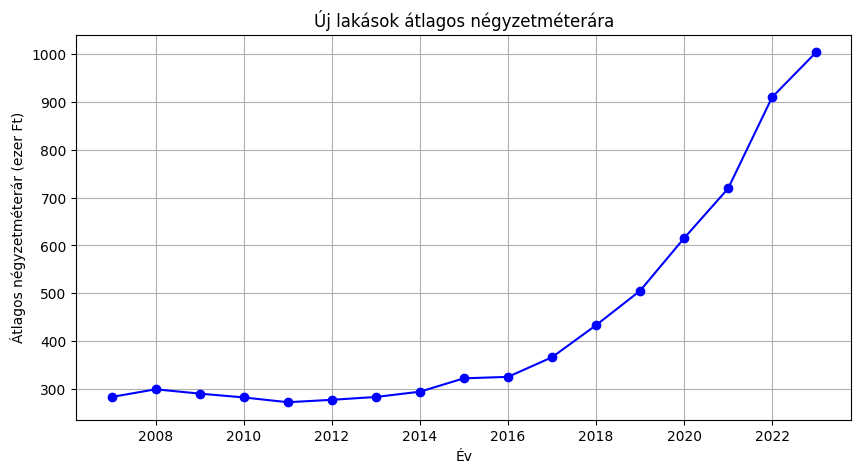

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "data/lakas_ar/stadat-lak0014-18.1.1.14-hu.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1", sep=";", skiprows=1)
df.rename(columns={df.columns[0]: "Épülettípus"}, inplace=True)
total_row = df[df["Épülettípus"] == "Összesen"].iloc[-1, 1:]
total_row = total_row.str.replace(" ", "").str.replace(",", ".")
total_row = total_row.astype(float)
mean_squared_years = total_row.index.astype(int)
values = total_row.values

plt.figure(figsize=(10, 5))
plt.plot(mean_squared_years, values, marker="o", linestyle="-", color="b")
plt.xlabel("Év")
plt.ylabel("Átlagos négyzetméterár (ezer Ft)")
plt.title("Új lakások átlagos négyzetméterára")
plt.grid(True)
plt.show()


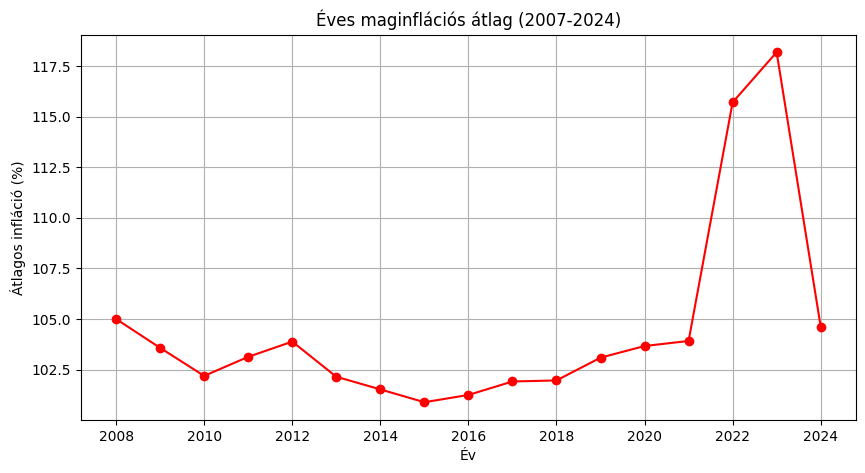

In [2]:
inflation_file_path = "data/inflacio/stadat-ara0045-1.2.1.9-hu.csv"
inflation_df = pd.read_csv(inflation_file_path, encoding="ISO-8859-1", sep=";", skiprows=3)
inflation_df.rename(columns={inflation_df.columns[0]: "Év"}, inplace=True)
inflation_df = inflation_df.iloc[12:29].copy()
inflation_df["Év"] = inflation_df["Év"].astype(str).str.extract("(\d+)").astype(int)
inflation_df = inflation_df.iloc[:, :13]

monthly_columns = inflation_df.columns[1:13]

for col in monthly_columns:
    inflation_df[col] = inflation_df[col].astype(str).str.replace(" ", "").str.replace(",", ".")
    inflation_df[col] = pd.to_numeric(inflation_df[col], errors="coerce")
inflation_avg = inflation_df.set_index("Év")[monthly_columns].mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(inflation_avg.index, inflation_avg.values, marker="o", linestyle="-", color="r")
plt.xlabel("Év")
plt.ylabel("Átlagos infláció (%)")
plt.title("Éves maginflációs átlag (2007-2024)")
plt.grid(True)
plt.show()


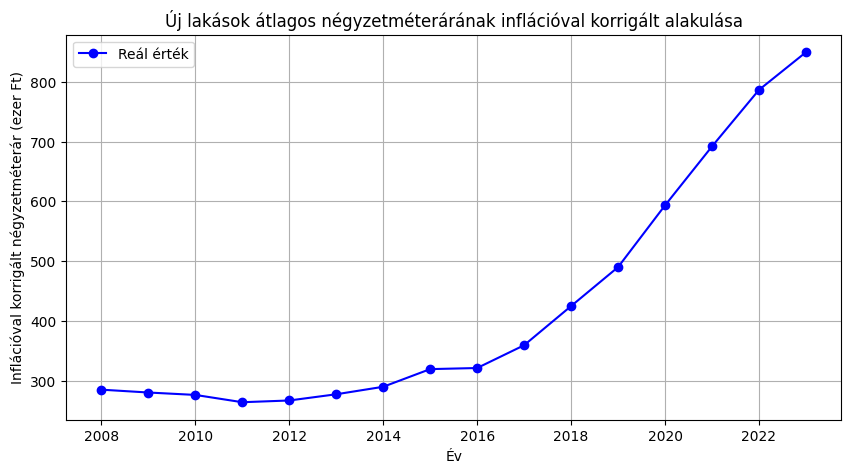

In [3]:
common_mean_squared_inflation_years = sorted(set(mean_squared_years) & set(inflation_avg.index))

inflation_corrected_values = [values[list(mean_squared_years).index(year)] / (inflation_avg[year] / 100) for year in common_mean_squared_inflation_years]

plt.figure(figsize=(10, 5))
plt.plot(common_mean_squared_inflation_years, inflation_corrected_values, marker="o", linestyle="-", color="b", label="Reál érték")
plt.xlabel("Év")
plt.ylabel("Inflációval korrigált négyzetméterár (ezer Ft)")
plt.title("Új lakások átlagos négyzetméterárának inflációval korrigált alakulása")
plt.grid(True)
plt.legend()
plt.show()


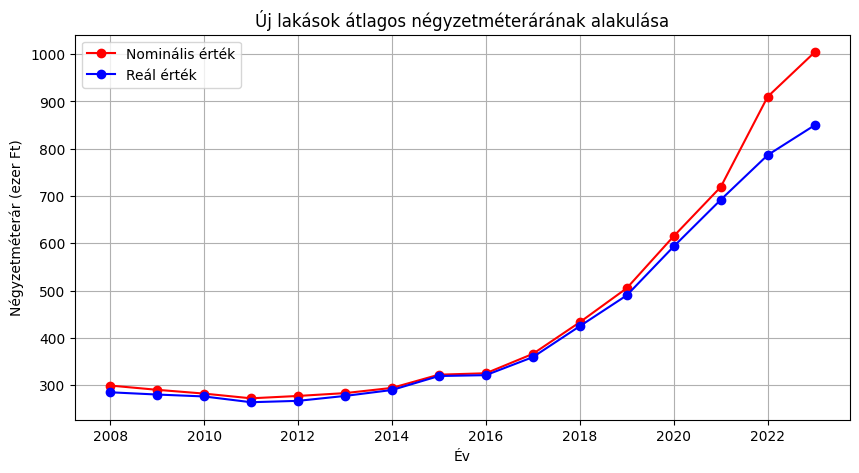

In [4]:
plt.figure(figsize=(10, 5))

plt.plot(common_mean_squared_inflation_years, [values[list(mean_squared_years).index(year)] for year in common_mean_squared_inflation_years], 
         marker="o", linestyle="-", color="r", label="Nominális érték")

plt.plot(common_mean_squared_inflation_years, inflation_corrected_values, 
         marker="o", linestyle="-", color="b", label="Reál érték")

plt.xlabel("Év")
plt.ylabel("Négyzetméterár (ezer Ft)")
plt.title("Új lakások átlagos négyzetméterárának alakulása")
plt.grid(True)
plt.legend()
plt.show()


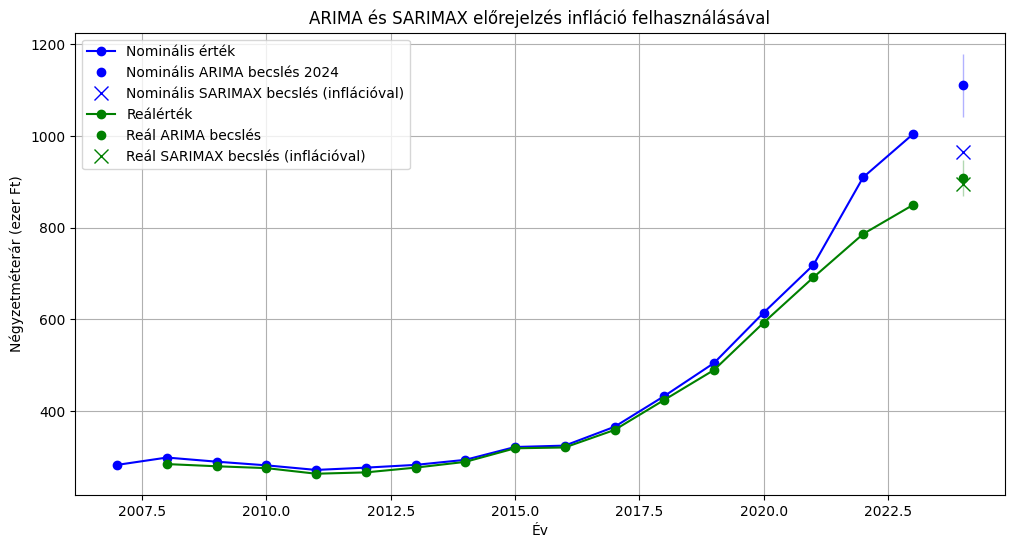

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.simplefilter("ignore")

nominal_series = pd.Series(values, index=mean_squared_years)
real_series = pd.Series(inflation_corrected_values, index=common_mean_squared_inflation_years)

# Inflációs értékek
exog_inflation = inflation_avg.loc[common_mean_squared_inflation_years + [2024]]

# ARIMA predikció infláció nélkül
def arima_predict(series):
    model = SARIMAX(series, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1)
    forecast_value = forecast.predicted_mean.iloc[0]
    conf_int = forecast.conf_int().iloc[0]
    return forecast_value, conf_int

# SARIMAX predikció infláció figyelembevételével
def sarimax_predict(series, exog):
    common_idx = series.index.intersection(exog.index[:-1])
    model = SARIMAX(series.loc[common_idx], order=(1, 1, 1), exog=exog.loc[common_idx])
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, exog=exog.iloc[[-1]])
    forecast_value = forecast.predicted_mean.iloc[0]
    conf_int = forecast.conf_int().iloc[0]
    return forecast_value, conf_int

# Becslések
nominal_forecast, nominal_conf = arima_predict(nominal_series)
real_forecast, real_conf = arima_predict(real_series)

nominal_sarimax_forecast, nominal_sarimax_conf = sarimax_predict(nominal_series, exog_inflation)
real_sarimax_forecast, real_sarimax_conf = sarimax_predict(real_series, exog_inflation)

plt.figure(figsize=(12, 6))

# Nominális értékek
plt.plot(nominal_series.index, nominal_series.values, marker="o", linestyle="-", color="blue", label="Nominális érték")
plt.plot(2024, nominal_forecast, 'bo', label="Nominális ARIMA becslés 2024")
plt.plot(2024, nominal_sarimax_forecast, 'bx', markersize=10, label="Nominális SARIMAX becslés (inflációval)")

# Reálérték
plt.plot(real_series.index, real_series.values, marker="o", linestyle="-", color="green", label="Reálérték")
plt.plot(2024, real_forecast, 'go', label="Reál ARIMA becslés")
plt.plot(2024, real_sarimax_forecast, 'gx', markersize=10, label="Reál SARIMAX becslés (inflációval)")

# Konfidencia intervallum (opcionális megjelenítés)
plt.fill_between([2024], nominal_conf[0], nominal_conf[1], color='blue', alpha=0.3)
plt.fill_between([2024], real_conf[0], real_conf[1], color="green", alpha=0.3)

plt.xlabel("Év")
plt.ylabel("Négyzetméterár (ezer Ft)")
plt.title("ARIMA és SARIMAX előrejelzés infláció felhasználásával")
plt.grid(True)
plt.legend()
plt.show()


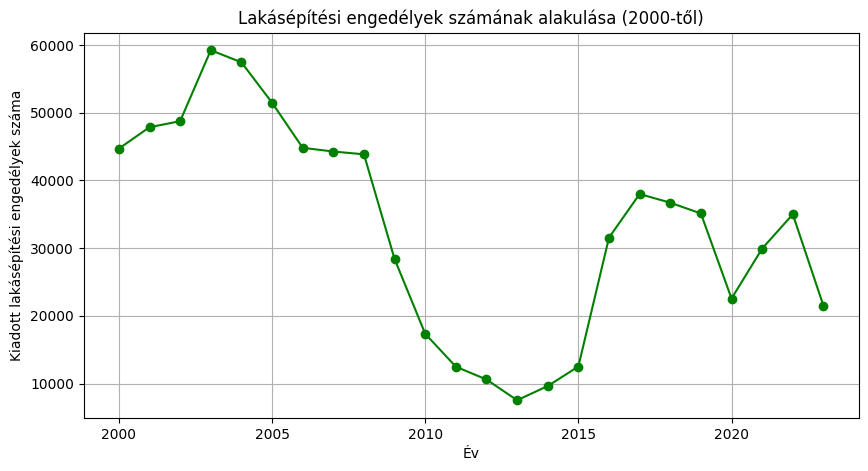

In [8]:
permit_file_path = "data/lakasepites/stadat-lak0006-18.1.1.6-hu.csv"

permit_df = pd.read_csv(permit_file_path, encoding="ISO-8859-1", sep=";", skiprows=1)
permit_df.rename(columns={permit_df.columns[0]: "Év", permit_df.columns[1]: "Engedélyek száma"}, inplace=True)
permit_df = permit_df.iloc[:].copy()
permit_df["Év"] = permit_df["Év"].astype(str).str.extract("(\d+)").astype(int)
permit_df["Engedélyek száma"] = permit_df["Engedélyek száma"].astype(str).str.replace(" ", "").astype(int)

plt.figure(figsize=(10, 5))
plt.plot(permit_df["Év"], permit_df["Engedélyek száma"], marker="o", linestyle="-", color="g")
plt.xlabel("Év")
plt.ylabel("Kiadott lakásépítési engedélyek száma")
plt.title("Lakásépítési engedélyek számának alakulása (2000-től)")
plt.grid(True)
plt.show()


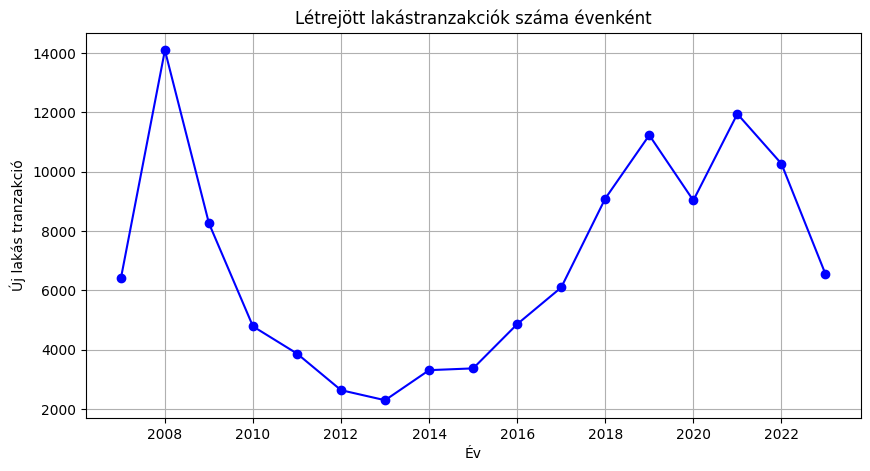

In [9]:
transactions_file_path = "data/tranzakcio_hitel/stadat-lak0015-18.1.1.15-hu.csv"

transactions_df = pd.read_csv(transactions_file_path, encoding="ISO-8859-1", sep=";", skiprows=1)
transactions_df.rename(columns={transactions_df.columns[0]: "Év", transactions_df.columns[2]: "Új lakás tranzakció"}, inplace=True)
transactions_df["Év"] = transactions_df["Év"].astype(str).str.extract("(\d+)").astype(int)
transactions_df["Új lakás tranzakció"] = transactions_df["Új lakás tranzakció"].astype(str).str.replace(" ", "").astype(int)

plt.figure(figsize=(10, 5))
plt.plot(transactions_df["Év"], transactions_df["Új lakás tranzakció"], marker="o", linestyle="-", color="b")
plt.xlabel("Év")
plt.ylabel("Új lakás tranzakció")
plt.title("Létrejött lakástranzakciók száma évenként")
plt.grid(True)
plt.show()


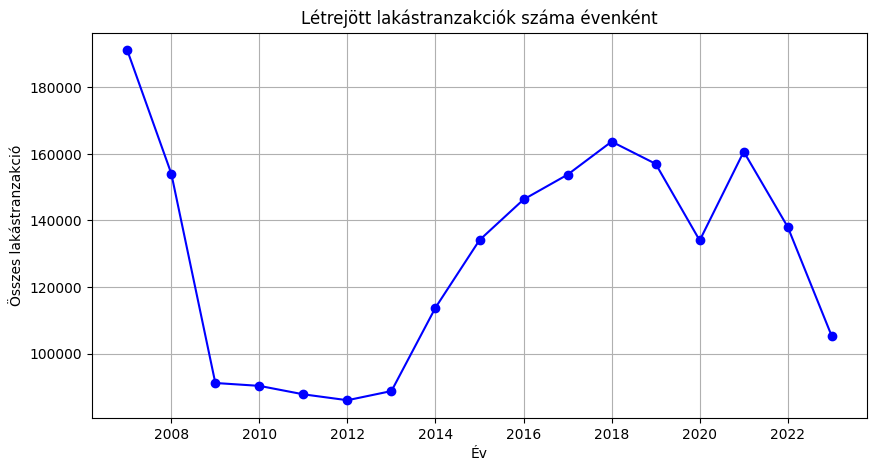

In [10]:
transactions_file_path = "data/tranzakcio_hitel/stadat-lak0015-18.1.1.15-hu.csv"

transactions_df = pd.read_csv(transactions_file_path, encoding="ISO-8859-1", sep=";", skiprows=1)
transactions_df.rename(columns={transactions_df.columns[0]: "Év", transactions_df.columns[3]: "Összes tranzakció"}, inplace=True)
transactions_df["Év"] = transactions_df["Év"].astype(str).str.extract("(\d+)").astype(int)
transactions_df["Összes tranzakció"] = transactions_df["Összes tranzakció"].astype(str).str.replace(" ", "").astype(int)

plt.figure(figsize=(10, 5))
plt.plot(transactions_df["Év"], transactions_df["Összes tranzakció"], marker="o", linestyle="-", color="b")
plt.xlabel("Év")
plt.ylabel("Összes lakástranzakció")
plt.title("Létrejött lakástranzakciók száma évenként")
plt.grid(True)
plt.show()


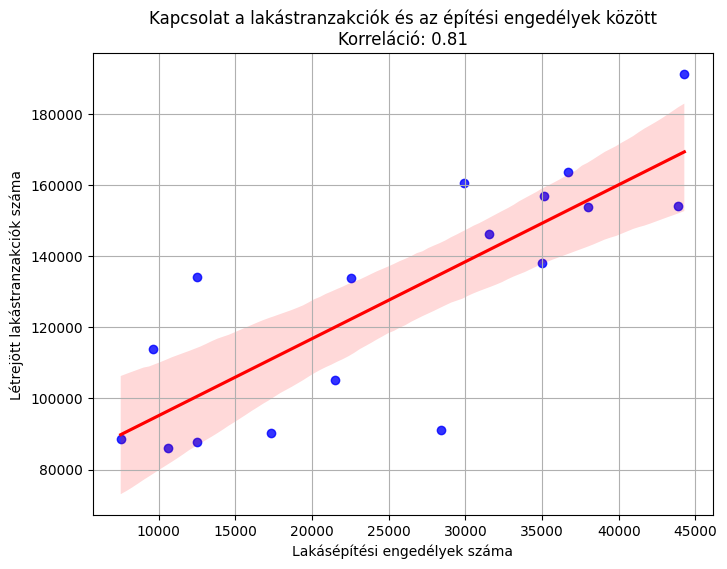

In [11]:
import seaborn as sns
import numpy as np

common_years = sorted(set(permit_df["Év"]) & set(transactions_df["Év"]))

permit_filtered = permit_df[permit_df["Év"].isin(common_years)].set_index("Év")

transactions_filtered = transactions_df[transactions_df["Év"].isin(common_years)].set_index("Év")

correlation_df = pd.DataFrame({
    "Lakásépítési engedélyek száma": permit_filtered["Engedélyek száma"],
    "Létrejött lakástranzakciók száma": transactions_filtered["Összes tranzakció"]
})

correlation_coefficient = correlation_df.corr().iloc[0, 1]

plt.figure(figsize=(8, 6))
sns.regplot(x="Lakásépítési engedélyek száma", y="Létrejött lakástranzakciók száma", data=correlation_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Lakásépítési engedélyek száma")
plt.ylabel("Létrejött lakástranzakciók száma")
plt.title(f"Kapcsolat a lakástranzakciók és az építési engedélyek között\nKorreláció: {correlation_coefficient:.2f}")
plt.grid(True)
plt.show()


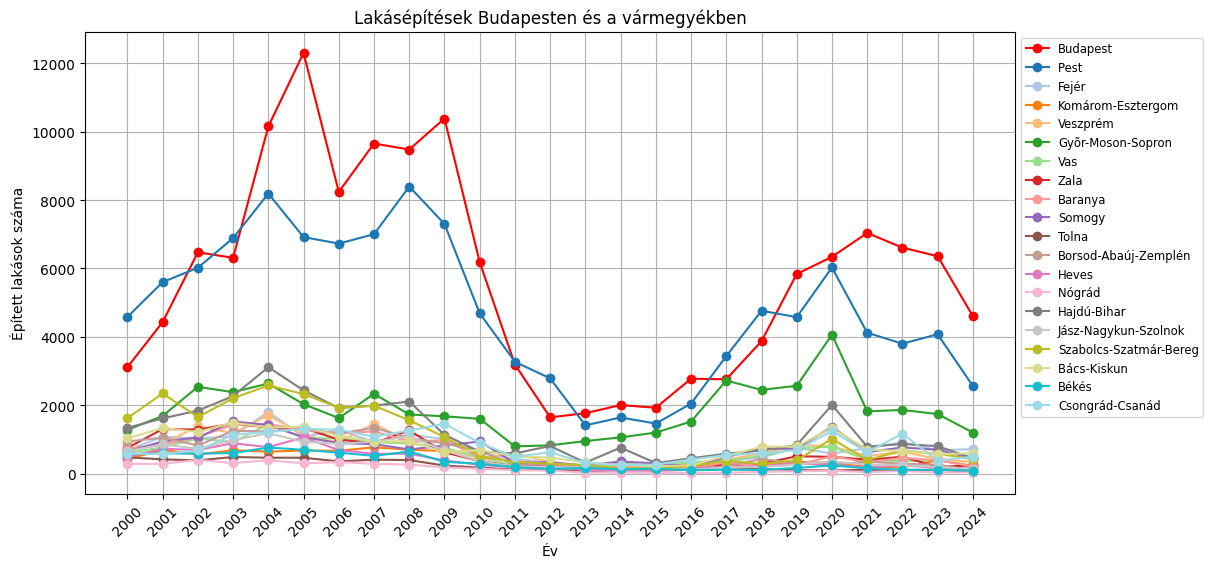

In [12]:
import matplotlib.cm as cm

construction_file_path = "data/lakasepites/stadat-lak0022-18.1.2.6-hu.csv"

construction_df = pd.read_csv(construction_file_path, encoding="ISO-8859-1", sep=";", skiprows=1)
construction_df.rename(columns={construction_df.columns[0]: "Terület", construction_df.columns[1]: "Típus"}, inplace=True)
construction_df = construction_df.iloc[:32].copy()

con_year_columns = construction_df.columns[2:].astype(str)

for col in con_year_columns:
    construction_df[col] = construction_df[col].astype(str).str.replace(" ", "").replace('nan', '0').astype(int)

budapest_df = construction_df[construction_df["Terület"] == "Budapest"]
county_df = construction_df[construction_df["Típus"].str.contains("vármegye", na=False)]


num_counties = len(county_df)
colors = cm.get_cmap("tab20", num_counties)

plt.figure(figsize=(12, 6))

plt.plot(con_year_columns, budapest_df[con_year_columns].values.flatten(), marker="o", linestyle="-", color="r", label="Budapest")
for idx, (_, row) in enumerate(county_df.iterrows()):
    plt.plot(con_year_columns, row[con_year_columns].values.flatten(), marker="o", linestyle="-", color=colors(idx / num_counties), label=row["Terület"])

plt.xlabel("Év")
plt.xticks(rotation=45)
plt.ylabel("Épített lakások száma")
plt.title("Lakásépítések Budapesten és a vármegyékben")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.grid(True)
plt.show()


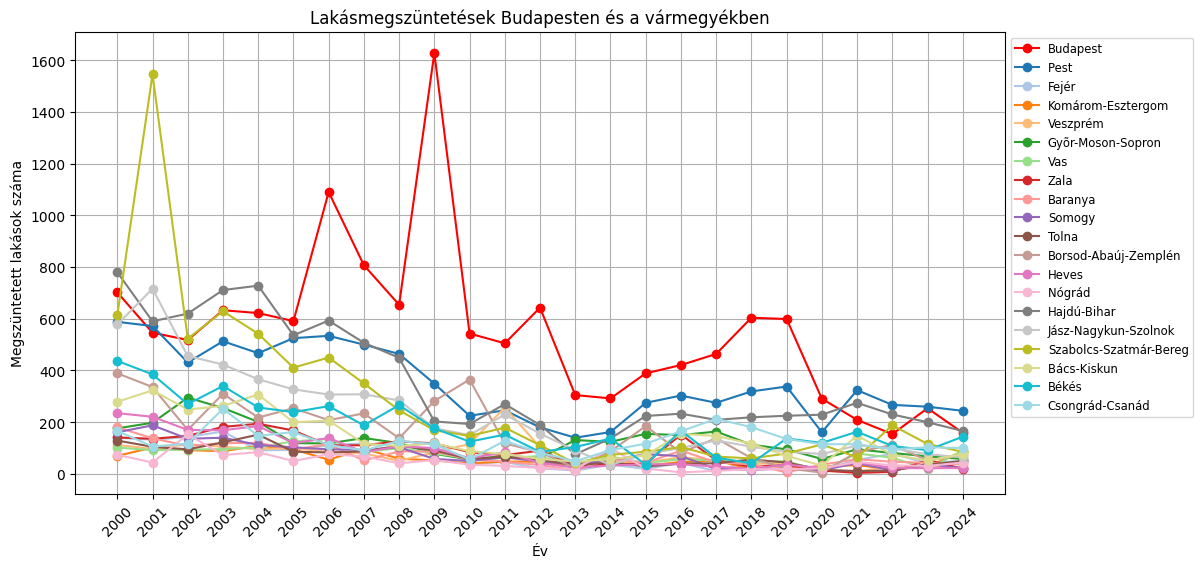

In [13]:
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt

deconstruction_file_path = "data/lakasepites/stadat-lak0022-18.1.2.6-hu.csv"

deconstruction_df = pd.read_csv(deconstruction_file_path, encoding="ISO-8859-1", sep=";", skiprows=1)
deconstruction_df.rename(columns={deconstruction_df.columns[0]: "Terület", deconstruction_df.columns[1]: "Típus"}, inplace=True)
deconstruction_df = deconstruction_df.iloc[125:157].copy()

decon_year_columns = deconstruction_df.columns[2:].astype(str)

for col in decon_year_columns:
    deconstruction_df[col] = deconstruction_df[col].astype(str).str.replace(" ", "").replace('nan', '0').astype(int)

decon_budapest_df = deconstruction_df[deconstruction_df["Terület"] == "Budapest"]
decon_county_df = deconstruction_df[deconstruction_df["Típus"].str.contains("vármegye", na=False)]

num_counties = len(decon_county_df)
colors = cm.get_cmap("tab20", num_counties)

plt.figure(figsize=(12, 6))

plt.plot(decon_year_columns, decon_budapest_df[decon_year_columns].values.flatten(), marker="o", linestyle="-", color="r", label="Budapest")

for idx, (_, row) in enumerate(decon_county_df.iterrows()):
    plt.plot(decon_year_columns, row[decon_year_columns].values.flatten(), marker="o", linestyle="-", color=colors(idx / num_counties), label=row["Terület"])

plt.xlabel("Év")
plt.xticks(rotation=45)
plt.ylabel("Megszüntetett lakások száma")
plt.title("Lakásmegszüntetések Budapesten és a vármegyékben")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.grid(True)
plt.show()


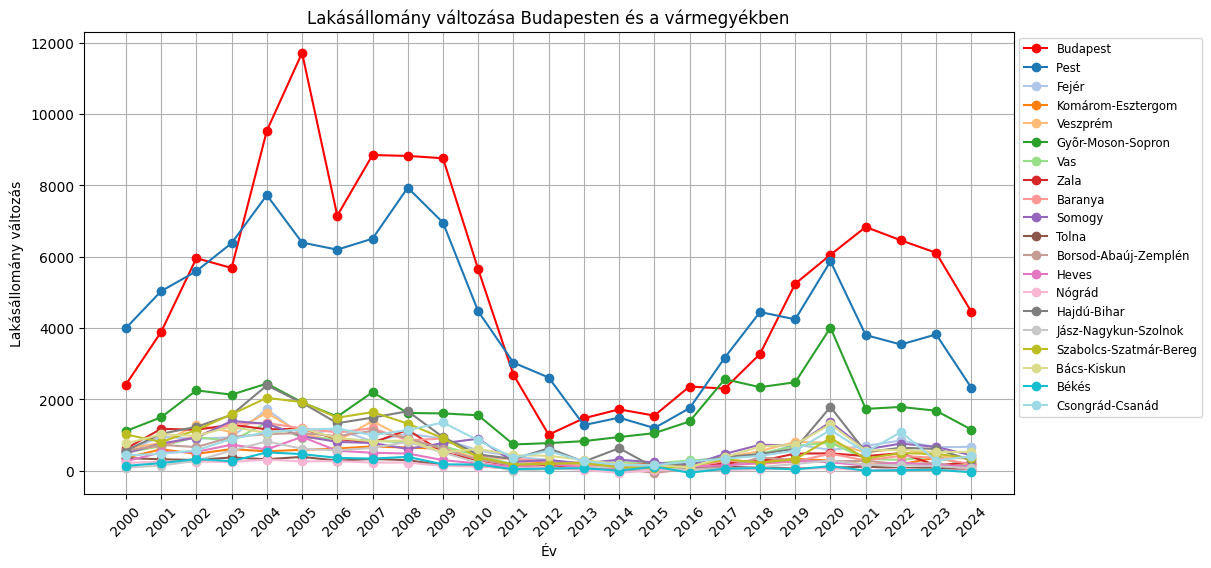

In [14]:
change_common_years = sorted(list(set(decon_year_columns) & set(con_year_columns)))

budapest_change = budapest_df[change_common_years].values.flatten() - decon_budapest_df[change_common_years].values.flatten()

county_change_df = county_df.copy()
for col in change_common_years:
    county_change_df[col] = county_df[col].values - decon_county_df[col].values

plt.figure(figsize=(12, 6))

plt.plot(change_common_years, budapest_change, marker="o", linestyle="-", color="r", label="Budapest")

for idx, (_, row) in enumerate(county_change_df.iterrows()):
    plt.plot(change_common_years, row[change_common_years].values.flatten(), marker="o", linestyle="-", color=colors(idx / num_counties), label=row["Terület"])

plt.xlabel("Év")
plt.xticks(rotation=45)
plt.ylabel("Lakásállomány változás")
plt.title("Lakásállomány változása Budapesten és a vármegyékben")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.grid(True)
plt.show()


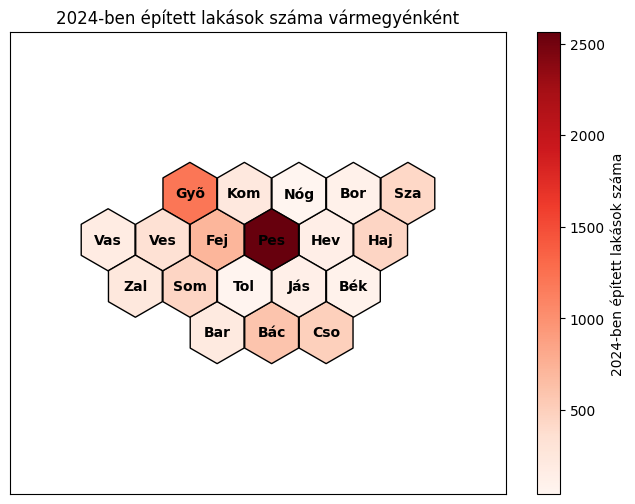

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

county_hex_coords = {
    "Bács-Kiskun ": (4.5, 6),
    "Baranya": (3.5, 6),
    "Békés": (6, 7),
    "Borsod-Abaúj-Zemplén": (6, 9),
    "Csongrád-Csanád": (5.5, 6),
    "Fejér": (3.5, 8),
    "Gyõr-Moson-Sopron": (3, 9),
    "Hajdú-Bihar": (6.5, 8),
    "Heves": (5.5, 8),
    "Jász-Nagykun-Szolnok": (5, 7),
    "Komárom-Esztergom": (4, 9),
    "Nógrád ": (5, 9),
    "Pest ": (4.5, 8),
    "Somogy": (3, 7),
    "Szabolcs-Szatmár-Bereg": (7, 9),
    "Tolna ": (4, 7),
    "Vas": (1.5, 8),
    "Veszprém": (2.5, 8),
    "Zala": (2, 7)
}

county_2024_data = county_df.set_index("Terület")["2024"]

hex_x = []
hex_y = []
hex_values = []
county_labels = []

for county, (x, y) in county_hex_coords.items():
    hex_x.append(x)
    hex_y.append(y)
    hex_values.append(county_2024_data[county])
    county_labels.append(county[:3])

plt.figure(figsize=(8, 6))
plt.scatter(hex_x, hex_y, c=hex_values, cmap="Reds", s=2000, marker="h", edgecolors="black")

plt.colorbar(label="2024-ben épített lakások száma")

for i, label in enumerate(county_labels):
    plt.text(hex_x[i], hex_y[i], label, ha="center", va="center", fontsize=10, fontweight="bold", color="black")

plt.xlim(min(hex_x) - 1.8, max(hex_x) + 1.8)
plt.ylim(min(hex_y) - 3.48, max(hex_y) + 3.48)

plt.xticks([])
plt.yticks([])
plt.title("2024-ben épített lakások száma vármegyénként")
plt.grid(False)
plt.show()

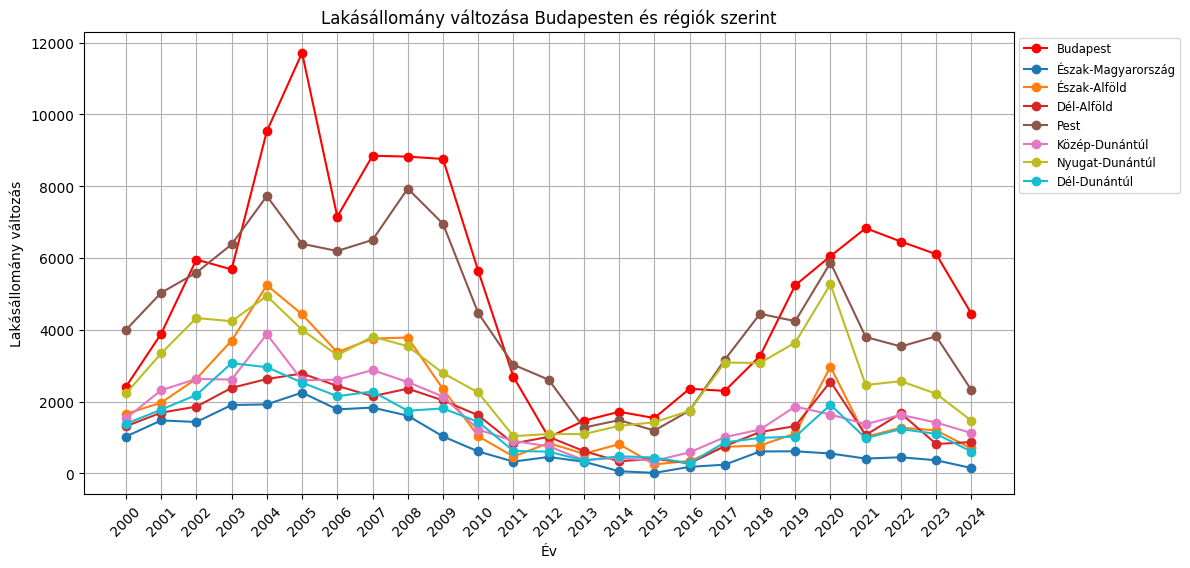

In [16]:
regions = {
    "Észak-Magyarország": ["Borsod-Abaúj-Zemplén", "Heves", "Nógrád "],
    "Észak-Alföld": ["Hajdú-Bihar", "Jász-Nagykun-Szolnok", "Szabolcs-Szatmár-Bereg"],
    "Dél-Alföld": ["Bács-Kiskun ", "Békés", "Csongrád-Csanád"],
    "Pest": ["Pest "],
    "Közép-Dunántúl": ["Fejér", "Komárom-Esztergom", "Veszprém"],
    "Nyugat-Dunántúl": ["Gyõr-Moson-Sopron", "Vas", "Zala"],
    "Dél-Dunántúl": ["Baranya", "Somogy", "Tolna "],
}
common_years = sorted(list(set(decon_year_columns) & set(con_year_columns)))

budapest_change = budapest_df[common_years].values.flatten() - decon_budapest_df[common_years].values.flatten()

region_change = {region: [] for region in regions.keys()}

for col in common_years:
    for region, counties in regions.items():
        selected_counties = county_df[county_df["Terület"].isin(counties)]
        selected_decon_counties = decon_county_df[decon_county_df["Terület"].isin(counties)]
        
        region_change[region].append(selected_counties[col].sum() - selected_decon_counties[col].sum())

plt.figure(figsize=(12, 6))

plt.plot(common_years, budapest_change, marker="o", linestyle="-", color="r", label="Budapest")

num_regions = len(region_change)
colors = cm.get_cmap("tab10", num_regions)

for idx, (region, values) in enumerate(region_change.items()):
    plt.plot(common_years, values, marker="o", linestyle="-", color=colors(idx / num_regions), label=region)

plt.xlabel("Év")
plt.xticks(rotation=45)
plt.ylabel("Lakásállomány változás")
plt.title("Lakásállomány változása Budapesten és régiók szerint")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.grid(True)
plt.show()


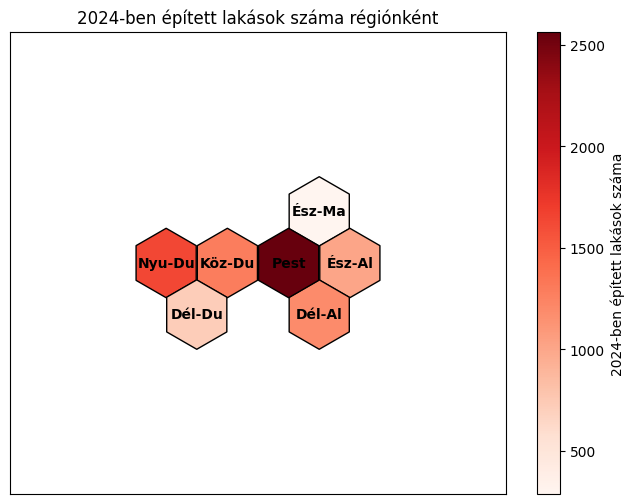

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

region_hex_coords = {
    "Észak-Magyarország": (5, 9),
    "Észak-Alföld": (5.5, 8),
    "Dél-Alföld": (5, 7),
    "Pest": (4.5, 8),
    "Közép-Dunántúl": (3.5, 8),
    "Nyugat-Dunántúl": (2.5, 8),
    "Dél-Dunántúl": (3, 7),
}

regions = {
    "Észak-Magyarország": ["Borsod-Abaúj-Zemplén", "Heves", "Nógrád "],
    "Észak-Alföld": ["Hajdú-Bihar", "Jász-Nagykun-Szolnok", "Szabolcs-Szatmár-Bereg"],
    "Dél-Alföld": ["Bács-Kiskun ", "Békés", "Csongrád-Csanád"],
    "Pest": ["Pest "],
    "Közép-Dunántúl": ["Fejér", "Komárom-Esztergom", "Veszprém"],
    "Nyugat-Dunántúl": ["Gyõr-Moson-Sopron", "Vas", "Zala"],
    "Dél-Dunántúl": ["Baranya", "Somogy", "Tolna "],
}

county_2024_data = county_df.set_index("Terület")["2024"]

region_values = {}

for region, counties in regions.items():
    region_value = sum([county_2024_data[county] for county in counties])
    region_values[region] = region_value

hex_x = []
hex_y = []
hex_values = []
region_labels = []

for region, (x, y) in region_hex_coords.items():
    hex_x.append(x)
    hex_y.append(y)
    hex_values.append(region_values[region])
    
    parts = region.split("-")
    if len(parts) > 1:
        short_label = parts[0][:3] + "-" + parts[1][:2]
    else:
        short_label = region[:6]
    
    region_labels.append(short_label)

plt.figure(figsize=(8, 6))
plt.scatter(hex_x, hex_y, c=hex_values, cmap="Reds", s=2500, marker="h", edgecolors="black")

plt.colorbar(label="2024-ben épített lakások száma")

for i, label in enumerate(region_labels):
    plt.text(hex_x[i], hex_y[i], label, ha="center", va="center", fontsize=10, fontweight="bold", color="black")

plt.xlim(min(hex_x) - 2.55, max(hex_x) + 2.55)
plt.ylim(min(hex_y) - 3.48, max(hex_y) + 3.48)

plt.xticks([])
plt.yticks([])
plt.title("2024-ben épített lakások száma régiónként")
plt.grid(False)
plt.show()


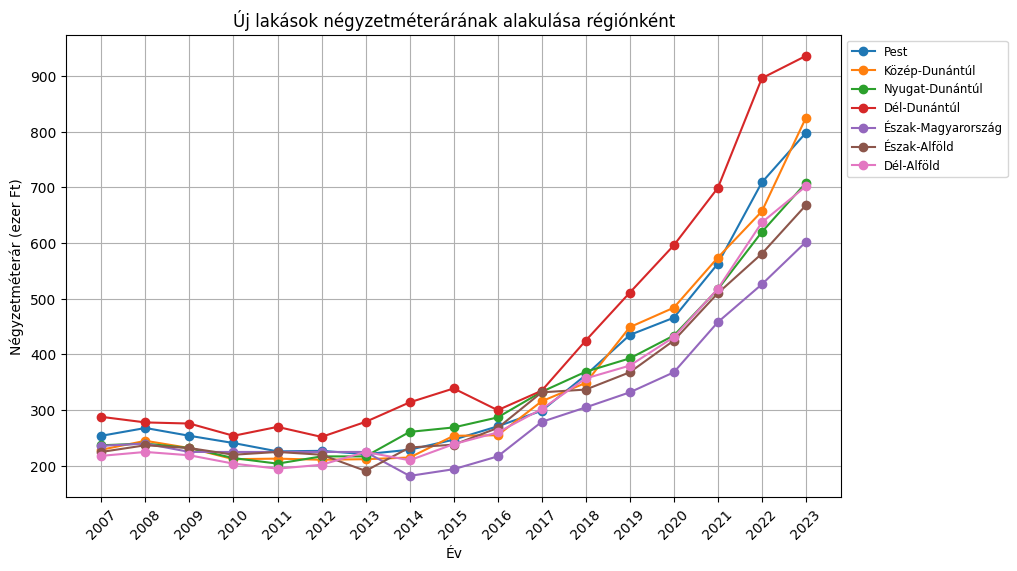

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "data/lakas_ar/stadat-lak0025-18.1.2.9-hu.csv"

df = pd.read_csv(file_path, encoding="ISO-8859-1", sep=";", skiprows=1)

df.rename(columns={df.columns[0]: "Régió", df.columns[1]: "Településtípus"}, inplace=True)

region_price_year_columns = df.columns[2:19]

df = df.iloc[38:65].copy()

region_price_df_filtered = df[df["Településtípus"].str.strip() == "együtt"].copy()

for col in region_price_year_columns:
    region_price_df_filtered[col] = region_price_df_filtered[col].astype(str).str.replace(" ", "").str.replace(",", ".")
    region_price_df_filtered[col] = region_price_df_filtered[col].replace("..", pd.NA)

region_price_df_filtered[region_price_year_columns] = region_price_df_filtered[region_price_year_columns].fillna(method="ffill", axis=1)

region_price_df_filtered[region_price_year_columns] = region_price_df_filtered[region_price_year_columns].astype(float)

plt.figure(figsize=(10, 6))

for _, row in region_price_df_filtered.iterrows():
    plt.plot(region_price_year_columns, row[region_price_year_columns], marker="o", linestyle="-", label=row["Régió"])

plt.xlabel("Év")
plt.xticks(rotation=45)
plt.ylabel("Négyzetméterár (ezer Ft)")
plt.title("Új lakások négyzetméterárának alakulása régiónként")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.grid(True)
plt.show()


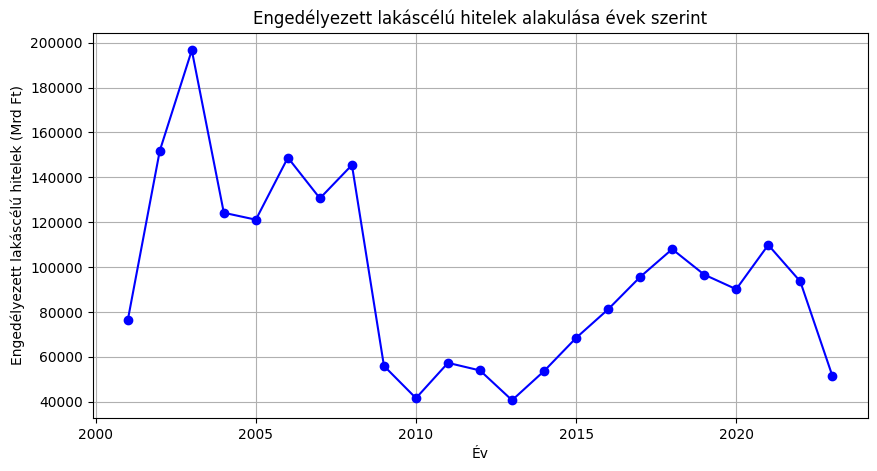

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "data/tranzakcio_hitel/stadat-lak0016-18.1.1.16-hu.csv"

df = pd.read_csv(file_path, encoding="ISO-8859-1", sep=";", skiprows=1)
df = df.iloc[35:40].copy()

loan_data = df[df["Megnevezés"].str.contains("Összesen", case=False, na=False)].iloc[-1, 1:].T

loan_data = loan_data.to_frame(name="Engedélyezett lakáscélú hitelek")

loan_data.index = loan_data.index.astype(str).str.strip().astype(int)

loan_data["Engedélyezett lakáscélú hitelek"] = loan_data["Engedélyezett lakáscélú hitelek"].astype(str).str.replace(" ", "").str.replace(",", ".").astype(float)

plt.figure(figsize=(10, 5))
plt.plot(loan_data.index, loan_data["Engedélyezett lakáscélú hitelek"], marker="o", linestyle="-", color="b")
plt.xlabel("Év")
plt.ylabel("Engedélyezett lakáscélú hitelek (Mrd Ft)")
plt.title("Engedélyezett lakáscélú hitelek alakulása évek szerint")
plt.grid(True)
plt.show()


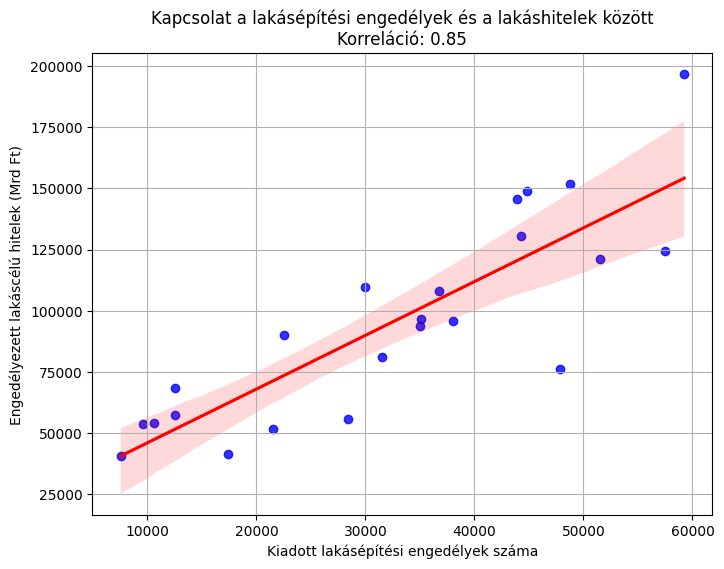

In [20]:
import seaborn as sns

merged_df = permit_df.merge(loan_data, left_on="Év", right_index=True, how="inner")

correlation_coefficient = merged_df["Engedélyek száma"].corr(merged_df["Engedélyezett lakáscélú hitelek"])

plt.figure(figsize=(8, 6))
sns.regplot(x="Engedélyek száma", y="Engedélyezett lakáscélú hitelek", data=merged_df,
            scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Kiadott lakásépítési engedélyek száma")
plt.ylabel("Engedélyezett lakáscélú hitelek (Mrd Ft)")
plt.title(f"Kapcsolat a lakásépítési engedélyek és a lakáshitelek között\nKorreláció: {correlation_coefficient:.2f}")
plt.grid(True)
plt.show()


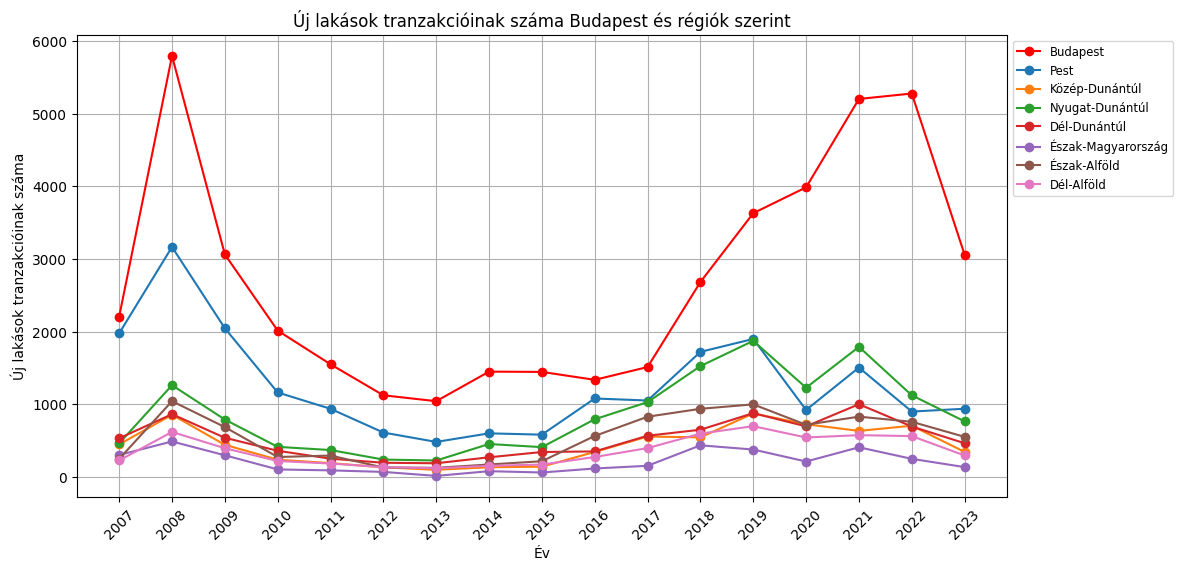

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

file_path = "data/tranzakcio_hitel/stadat-lak0026-18.1.2.10-hu.csv"

df = pd.read_csv(file_path, encoding="ISO-8859-1", sep=";", skiprows=1)

df.rename(columns={df.columns[0]: "Régió", df.columns[1]: "Típus"}, inplace=True)

trans_year_columns = df.columns[2:].astype(str)

df_filtered = df.iloc[35:].copy()

def clean_numeric(value):
    if isinstance(value, str):
        value = re.sub(r"[^\d,.-]", "", value)
        value = value.replace(",", ".")
    return value if value else np.nan

for col in trans_year_columns:
    df_filtered[col] = df_filtered[col].astype(str).apply(clean_numeric).astype(float)

budapest_df = df_filtered[df_filtered["Régió"].str.strip() == "Budapest"]

trans_region_df = df_filtered[(df_filtered["Típus"].str.strip() == "együtt") & (df_filtered["Régió"] != "Budapest")]

plt.figure(figsize=(12, 6))

if not budapest_df.empty:
    plt.plot(trans_year_columns, budapest_df[trans_year_columns].values.flatten(), marker="o", linestyle="-", color="r", label="Budapest")

for _, row in trans_region_df.iterrows():
    plt.plot(trans_year_columns, row[trans_year_columns].values.flatten(), marker="o", linestyle="-", label=row["Régió"])

plt.xlabel("Év")
plt.xticks(rotation=45)
plt.ylabel("Új lakások tranzakcióinak száma")
plt.title("Új lakások tranzakcióinak száma Budapest és régiók szerint")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.grid(True)
plt.show()


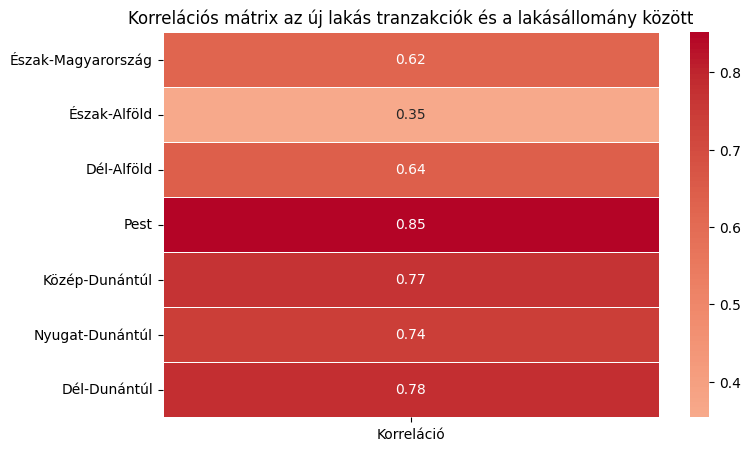

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

trans_change_common_years = sorted(set(trans_year_columns) & set(change_common_years))

correlation_matrix = pd.DataFrame(
    {
        region: np.corrcoef(
            region_change[region][-len(trans_change_common_years):],
            trans_region_df[trans_region_df["Régió"] == region][trans_change_common_years].values.flatten()
        )[0, 1]
        for region in regions.keys() if region in trans_region_df["Régió"].values
    },
    index=["Korreláció"]
).T

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

plt.title("Korrelációs mátrix az új lakás tranzakciók és a lakásállomány között")
plt.show()


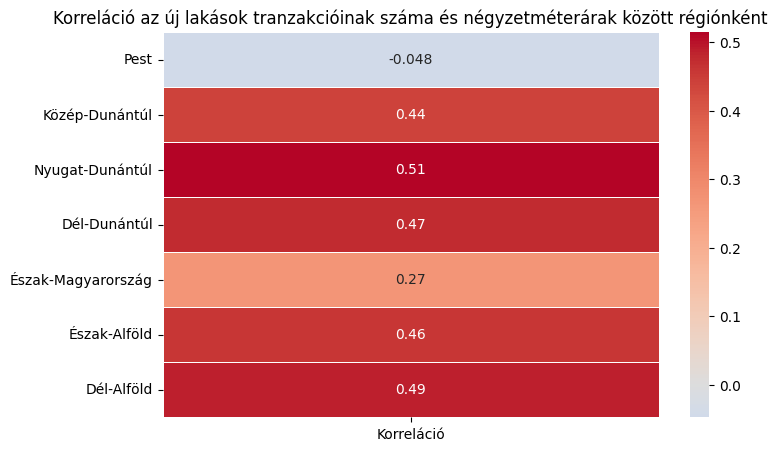

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

common_years = sorted(set(region_price_year_columns) & set(trans_year_columns))

correlation_data = {}
for region in trans_region_df["Régió"].values:
    if region in region_price_df_filtered["Régió"].values:
        transactions = trans_region_df[trans_region_df["Régió"] == region][common_years].values.flatten()
        prices = region_price_df_filtered[region_price_df_filtered["Régió"] == region][common_years].values.flatten()
        
        if len(transactions) == len(prices) and len(transactions) > 1:
            correlation_value = np.corrcoef(transactions, prices)[0, 1]
            correlation_data[region] = correlation_value
        else:
            print(f"⚠️ Skipping {region}: Nem megfelelő adatméretek! ({len(transactions)} és {len(prices)})")

correlation_matrix = pd.DataFrame(correlation_data, index=["Korreláció"]).T

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

plt.title("Korreláció az új lakások tranzakcióinak száma és négyzetméterárak között régiónként")
plt.show()
